# Feature detection part 2

In this notebook, we will take a detailed look at tobac's feature detection and examine the remaining parameters.

In [1]:
import tobac
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import seaborn as sns
sns.set_context('talk')

%matplotlib inline

## n_erosion_threshold

To understand this parameter we have to look at one varibale of the feature-Datasets we did not mention so far: *num*

The value of *num* for a specific feature tells us the number of datapoints of the feature exceeding the threshold. *n_erosion_threshold* reduces this number by [eroding](https://en.wikipedia.org/wiki/Erosion_%28morphology%29) the mask of the feature. Supose we are looking at the gaussian data again and we set a treshold of 0.5. The resulting mask of our feature will look like this:

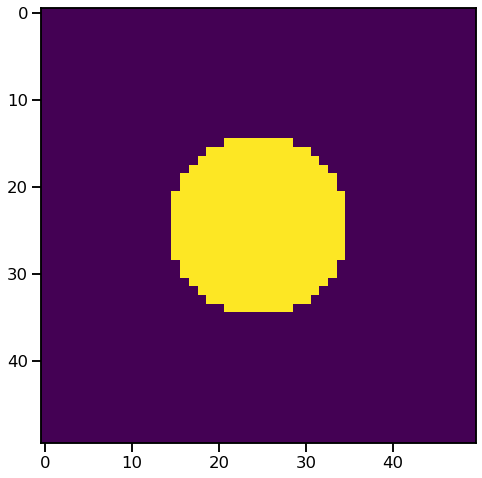

In [9]:
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

exp = np.exp(-(xx**2+yy**2))

gaussian_data = np.expand_dims(exp, axis=0)
threshold = 0.5

mask = gaussian_data > threshold
mask = mask[0]

plt.figure(figsize = (8, 8))
plt.imshow(mask)

The algorithm used by tobac is imported from *skimage.morphology*:

In [5]:
from skimage.morphology import binary_erosion

Applying this algorithm requires a quadratic matrix. This size of this matrix is provided by the *n_erosion_threshold* parameter. For a quick demonstration we can create the matrix by hand and apply the erosion for different values:

Text(0.5, 1.0, '$n = 10$')

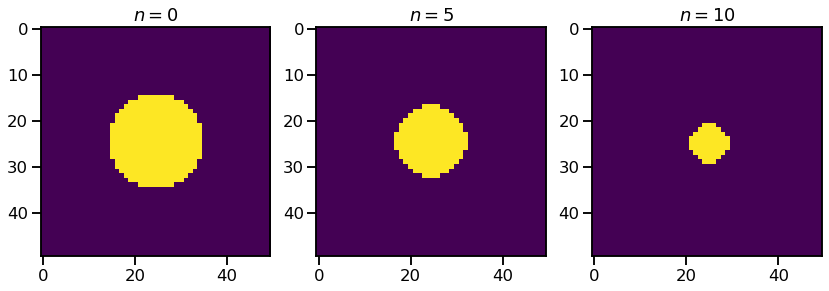

In [10]:
fig, axes = plt.subplots(ncols = 3, figsize = (14, 10))

im0 = axes[0].imshow(mask)
axes[0].set_title(r'$n= 0$')

n_erosion_threshold = 5
selem = np.ones((n_erosion_threshold, n_erosion_threshold))
mask_er = binary_erosion(mask, selem).astype(np.int64)

im1 = axes[1].imshow(mask_er)
axes[1].set_title(r'$n = 5$')

n_erosion_threshold = 10
selem = np.ones((n_erosion_threshold, n_erosion_threshold))
mask_er_more = binary_erosion(mask, selem).astype(np.int64)

im2 = axes[2].imshow(mask_er_more)
axes[2].set_title(r'$n = 10$')

This means if by using increasing values of *n_erosion_threshold* we will get lower values of *num*, which will match the number of **True**-values in the masks above:

In [38]:
%%capture

date = np.datetime64('2022-04-01T00:00' )
input_data = xr.DataArray(data=gaussian_data, coords={'time':np.expand_dims(date, axis = 0),'y':y, 'x':x})
dxy = (input_data['x'][1] - input_data['x'][0])

features = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, n_erosion_threshold=0)
features_eroded = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, n_erosion_threshold=5)
features_eroded_more = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, n_erosion_threshold=10)

In [39]:
features['num'].data[0]

332

In [42]:
mask.sum()

332

In [40]:
features_eroded['num'].data[0]

188

In [43]:
mask_er.sum()

188

In [41]:
features_eroded_more['num'].data[0]

57

In [44]:
mask_er_more.sum()

57

**Use???**

## n_min_threshold

With *n_min_threshold* parameter we can exclude smaller features by setting a minimum of datapoints that have to exceed the threshold for one feature. If we again detect the single feature of our gaussian data and check its *num* value, we can see that it contains 332 pixels:

In [47]:
%%capture

threshold = 0.5
features = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold)

In [48]:
features['num'].data

array([332])

If we now use an *n_min-threshold* above or equal this value, we will detect no features:

In [49]:
features = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, n_min_threshold=332)

In [50]:
print(features)

None


This can be usefull for feature detection in noisy data.

## min_distance

With *min_distance* we can set a minimal distance of our features. All features closer than this distance to an allready detected feature will be neclected. The 3 blobs can be used again for illustration.. The data is imported and the features are detected as before:

In [51]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs()

thresholds = [9]
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, min_distance=0)

A quick look at frame 50 tells us the found features and their indices:

In [ ]:
n = 50
mask = features['frame'] == n
features_frame = features.where(mask).dropna('index').to_dataframe()
features_frame.index.values

Notice that *to_dataframe()* was used to convert the Dataset to a pandas dataframe, which is required to use the *calculate_distance* function of the analysis module:

In [ ]:
tobac.analysis.analysis.calculate_distance(features_time.loc[60], features_time.loc[61], method_distance='xy')

In [ ]:
tobac.analysis.analysis.calculate_distance(features_time.loc[62], features_time.loc[61], method_distance='xy')

In [ ]:
tobac.analysis.analysis.calculate_distance(features_time.loc[62], features_time.loc[60], method_distance='xy')

No we know how far our features are apart. With this knowledge we can set reasonable values for *min_distance*. For example, if we only wanna detect one feature, we can set

In [ ]:
min_distance=101608

and perform the feature detection as usual:

In [ ]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs()

thresholds = [10]
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, min_distance = min_distance)

n = 50
mask = features['frame'] == n

Plotting the result shows us that we have only detected feature 1, like we expected.

In [ ]:
fig, ax1 = plt.subplots(ncols = 1, figsize = (10, 10))
ax1.imshow(data.data[50], cmap = 'Greys')

im1 = ax1.scatter(features.where(mask)['hdim_2'], features.where(mask)['hdim_1'], color = 'red')

## wavelength_filtering

| **Parameter** | done |
| threshold     | yes  |
    min_num=0
    target="maximum"
    position_threshold="center",
    sigma_threshold=0.5
    n_erosion_threshold=0
    n_min_threshold=0
    min_distance=0
    feature_number_start=1
    wavelength_filtering=None

In [ ]:
axes